# Working - Foster Care Analysis
This file is a working document for the Foster Care Analysis project. This is not the final version of the project. The final version will be published in a separate file.

In [44]:
# import the necessary packages

from google.cloud import storage
import pandas as pd
import numpy as np

# show all columns
pd.set_option('display.max_columns', None)

from dotenv import load_dotenv
import os

# import function files and environment variables
import utils

# reload the imports
import importlib

# Import the plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

# Import the needed ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load the .env file
load_dotenv()

# Connect to the Google Cloud Storage bucket
service_account_path = 'GOOGLE_APPLICATION_CREDENTIALS.json'
client = storage.Client.from_service_account_json(service_account_path)
bucket_name = 'foster-care'
bucket = client.get_bucket(bucket_name)

In [3]:
importlib.reload(utils)

<module 'utils' from '/Users/topanga37/github/DATASCI207_Sec03/Final Project/utils.py'>

## Read Data

In [4]:
# Read in Variable Values and Variable Definitions
variable_values_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variable Values.xlsx')) # Mapping
variables_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variables.xlsx')) # Variable Definitions

In [5]:
# Read in the raw data
raw_df_2001 = pd.read_sas(utils.read_cloud_data(bucket, '2001.sas7bdat'), format='sas7bdat') 
#raw_df_2002 = pd.read_csv(utils.read_cloud_data(bucket, '2002.tab'), sep='\t', lineterminator='\n')
#raw_df_2003 = pd.read_sas(utils.read_cloud_data(bucket, '2003.sas7bdat'), format='sas7bdat') 

In [6]:
# Run a function to make the data readable
df_2001 = utils.make_readable(raw_df_2001, variable_values_df)
#df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)
#df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)

# Filter and Clean Data

In [7]:
# all_records = pd.concat([df_2001, df_2002, df_2003], axis=0)
all_records = df_2001.reset_index(drop=True) # temporarily doing 2001 only so that the code runs faster
all_records = utils.remove_nan_values(all_records)

Age Unknown: 0

Total Null Values: 2
Total Records: 813138
Total Columns: 61


In [8]:
all_records.notnull().sum()

DataYear               813138
RecNumbr               813136
MR                     813138
VISHEAR                813138
PHYDIS                 813138
                        ...  
dischargeReason        813138
raceEthnicity          813138
everAdopted            813138
diagnosedDisability    813138
age2021                813138
Length: 61, dtype: int64

In [9]:
# keep only the cases where the child has exited foster care
exited_df = all_records[all_records['Exited'] == 1]
print(exited_df.shape)

(268761, 61)


In [10]:
# Create Binary label for if they have reunified
exited_df['reunified'] = 0
exited_df.loc[(exited_df['Exited'] == 1) & (exited_df['dischargeReason'] == 'Reunified with parent, primary caretaker'), 'reunified'] = 1

/var/folders/nn/49kzzxpn0r91n0t4vclvggy40000gn/T/ipykernel_81760/186036490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exited_df['reunified'] = 0


In [11]:
# Drop columns that are are duplicative
exited_df = exited_df.drop(columns=['Exited', 'dischargeReason'])

# Visualizing the data

In [13]:
chart_df = exited_df[exited_df['AgeAtEnd'] <= 21]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


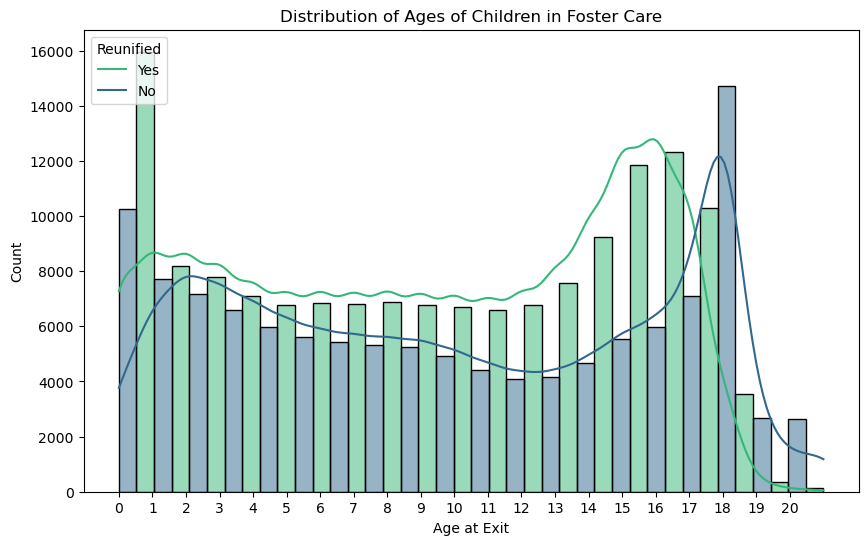

In [14]:
# Create a histogram of the ages of the children in the dataset separated by whether they were reunified or not
plt.figure(figsize=(10, 6))
sns.histplot(chart_df, x='AgeAtEnd', hue='reunified', bins=20, kde=True, palette='viridis', multiple='dodge')
plt.title('Distribution of Ages of Children in Foster Care')
plt.xlabel('Age at Exit')
plt.ylabel('Count')
plt.xticks(np.arange(0, 21, 1))
plt.legend(title='Reunified', labels=['Yes', 'No'], loc='upper left')
# for p in plt.gca().patches:
    # plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

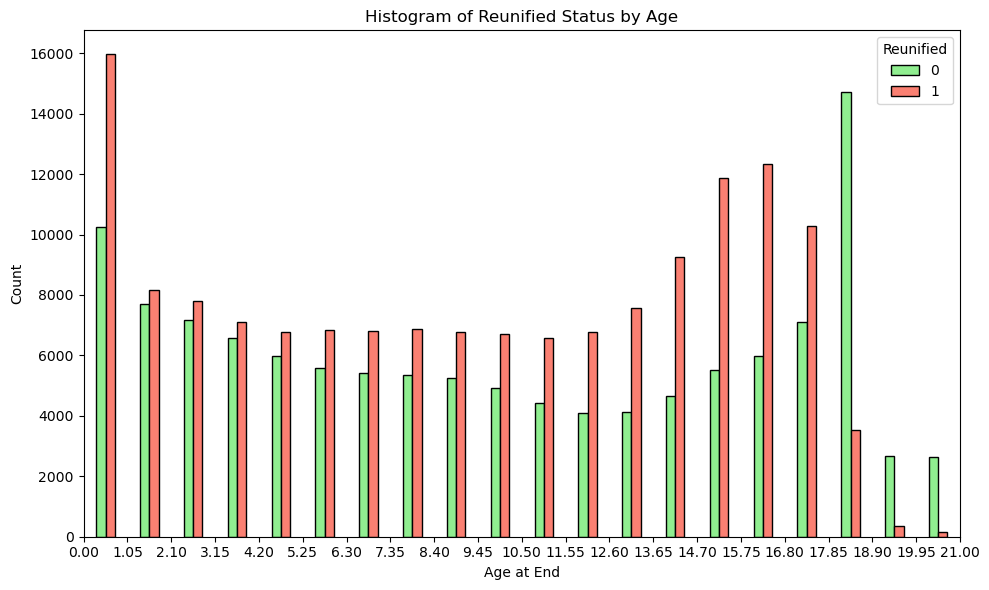

In [15]:
# Filter the DataFrame for each category in 'reunified'
group1 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[0]]['AgeAtEnd']
group2 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[1]]['AgeAtEnd']

plt.figure(figsize=(10, 6))

# Set the positions of the bars
bins = np.histogram_bin_edges(chart_df['AgeAtEnd'], bins=20)
width = (bins[1] - bins[0]) * 0.4

plt.hist([group1, group2], bins=bins, label=[str(chart_df['reunified'].unique()[0]), str(chart_df['reunified'].unique()[1])], 
         color=['lightgreen', 'salmon'], edgecolor='black', rwidth=width, align='mid', histtype='bar')

plt.legend(title='Reunified')
plt.xlabel('Age at End')
plt.ylabel('Count')
plt.title('Histogram of Reunified Status by Age')

plt.xticks(bins.round(2))
plt.xlim([bins.min(), bins.max()])  
plt.tight_layout()
plt.show()


Text(0, 0.5, '% Reunified')

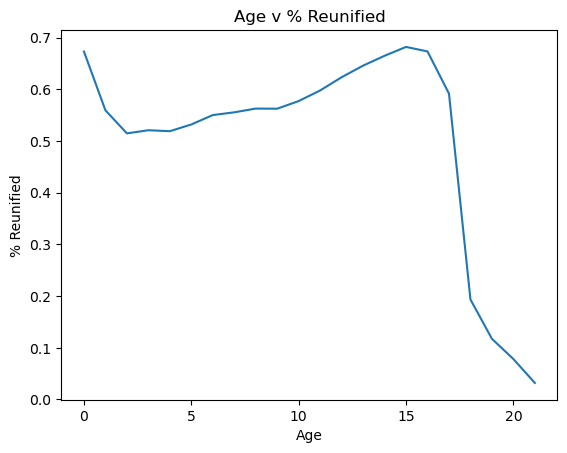

In [16]:
# plot age v % that reunified
age_reunified = chart_df.groupby('AgeAtEnd')['reunified'].mean()
age_reunified.plot()
plt.title('Age v % Reunified')
plt.xlabel('Age')
plt.ylabel('% Reunified')

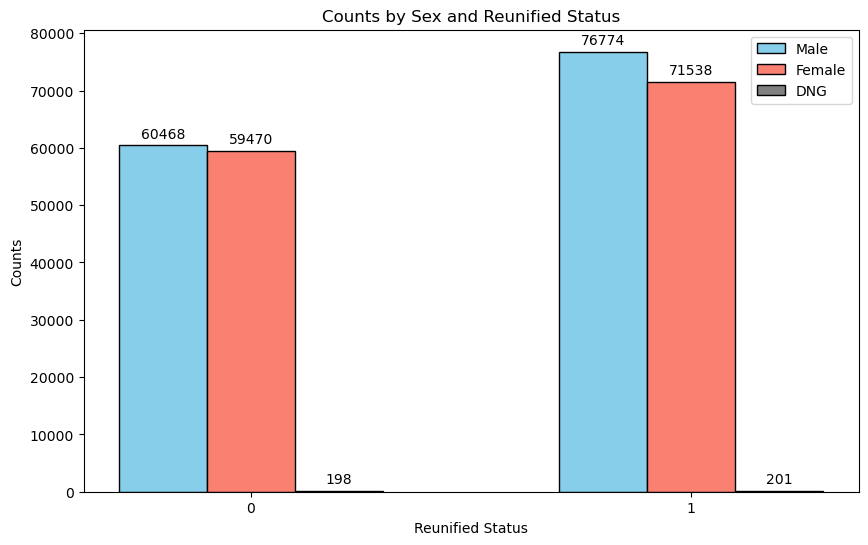

In [17]:
count_matrix = chart_df.groupby(['reunified', 'Sex']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(len(count_matrix))
width = 0.2 # the width of the bars

# Plotting the bars
bars1 = ax.bar(ind - width, count_matrix['Male'], width, label='Male', color='skyblue', edgecolor='black')
bars2 = ax.bar(ind, count_matrix['Female'], width, label='Female', color='salmon', edgecolor='black')
bars3 = ax.bar(ind + width, count_matrix['DNG'], width, label='DNG', color='grey', edgecolor='black')

ax.set_xlabel('Reunified Status')
ax.set_ylabel('Counts')
ax.set_title('Counts by Sex and Reunified Status')
ax.set_xticks(ind)
ax.set_xticklabels(count_matrix.index)
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)
ax.bar_label(bars3, padding=3)

plt.show()


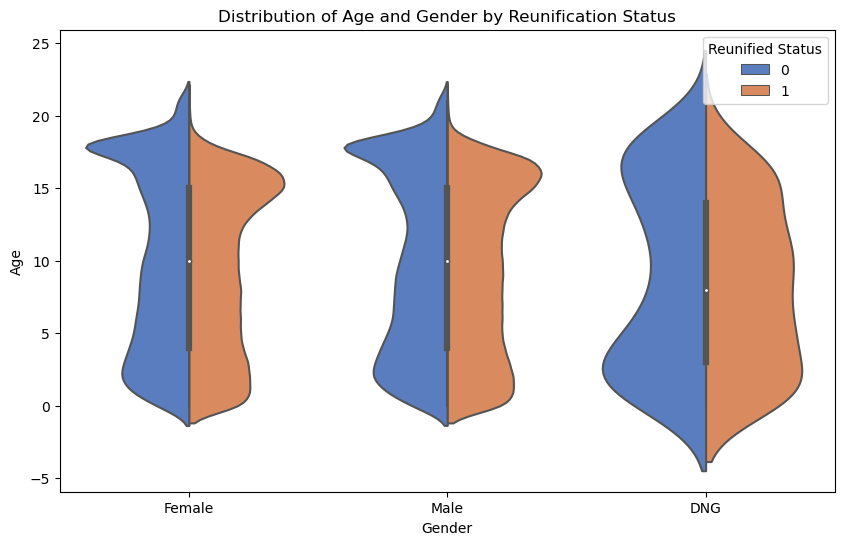

In [18]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Sex", y="AgeAtEnd", hue="reunified", data=chart_df, palette="muted", split=True)

plt.title('Distribution of Age and Gender by Reunification Status')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Reunified Status')

plt.show()

# Creating Train-Validation-Test Datasets

In [34]:
# Shuffle the data randomly to avoid any biases
exited_df = exited_df.sample(frac = 1, random_state=42)

In [38]:
# Split the data into three sections: training at 60%, validation at 20%, and testing at 20%
ml_data_df = exited_df.drop(['DataYear', 'RecNumbr', 'age2021', 'caseGoal', 'AgeAtStart', 'AgedOut'], axis=1)
ml_df = pd.get_dummies(ml_data_df, columns=['State', 'FIPSCode', 'Sex', 'removalManner', 'currentPlacementSetting', 'caretakerFamilyStructure', 'fosterFamilyStructure',  'raceEthnicity', 'diagnosedDisability', 'AgeAdopt', 'everAdopted', 'OutOfStatePlacement']) 

X = ml_df.drop('reunified', axis=1)  # Features
y = ml_df['reunified']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(161256, 266)
(53752, 266)
(53753, 266)


## Baseline the Model

In [41]:
# Look at the baseline for the training dataset 
print(f"Not Reunified in Training Data: {y_train.value_counts()[0]}")
print(f"Reunified in Training Data: {y_train.value_counts()[1]}")
baseline = y_train.value_counts()[1] / len(y_train)
print(f"\nPercentage Reunified, Training Baseline: {round(baseline*100, 2)}%")

Not Reunified in Training Data: 72236
Reunified in Training Data: 89020

Percentage Reunified, Training Baseline: 55.2%


In [42]:
# Calculate the baseline loss for the training dataset

def log_loss(Y_true, Y_pred):
  """Returns the binary log loss for a list of labels and predictions.
  
  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

  Returns:
    Binary log loss
  """
  loss = -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))
  return loss

# Use the log_loss function to evaluate our baseline on the train, validation, and test dataset using the average of reunified as our predicted probability.

train_loss = log_loss(y_train, baseline)
val_loss = log_loss(y_val, baseline)
test_loss = log_loss(y_test, baseline)

print("Log Loss for Baseline on Training Dataset:", train_loss)
print("Log Loss for Baseline on Validation Dataset:", val_loss)
print("Log Loss for Baseline on Test Dataset:", test_loss)

Log Loss for Baseline on Training Dataset: 0.687720727851345
Log Loss for Baseline on Validation Dataset: 0.6880679474105265
Log Loss for Baseline on Test Dataset: 0.6867213968889204


# ALL ABOVE CODE IS SET FOR MODEL TESTING

# Random Forest

In [43]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Predictions
y_pred = rf.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification report
print(classification_report(y_test, y_pred))

In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:15].plot(kind='bar', figsize=(6, 3))
plt.title('Feature Importance')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
from sklearn.tree import plot_tree

# Pick a single tree from the forest
single_tree = rf.estimators_[0]

plt.figure(figsize=(60,30))
plot_tree(single_tree, filled=True, feature_names=X.columns, max_depth=4, proportion=True)
plt.show()

# XG Boost Model

In [ ]:
import xgboost as xgb

# Convert the datasets to DMatrix data structure (optional step for improved performance)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model training parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # You can change this to 'auc' or other relevant metrics
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [ ]:
# Making predictions
y_pred_proba = bst.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]  # Convert probabilities to binary output

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

In [ ]:
# from sklearn.model_selection import GridSearchCV

# xgb_model = xgb.XGBClassifier()
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print(grid_search.best_params_)
# print(grid_search.best_score_)

# KNN Model

In [ ]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# CNN Model

In [ ]:
import tensorflow as tf

In [ ]:
age = np.array(X_train['AgeAtEnd'])[10:20]
print("Ages:", age)

age_bins = [0, 5, 10, 15, 20]
age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
print("Age Bins:", age_binned)

age_id = tf.keras.layers.IntegerLookup(vocabulary=np.arange(0, len(age_bins)+1), output_mode='one_hot')(age_binned)
print('Ages as one-hot:', age_id)

In [ ]:
def build_model():
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')

    age_bins = [0, 5, 10, 15, 20, 30]
    age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
    age_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(age_bins)+1),
        output_mode='one_hot')(age_binned)
    
    sex_id = tf.keras.layers.StringLookup(
        vocabulary=['Male', 'Female', 'DNG'], output_mode='one_hot')(sex)
    
    features = tf.keras.layers.Concatenate()([age_id, sex_id])

    dense = tf.keras.layers.Dense(
        units=12, activation='tanh', name='hidden1')(features)

    reunified = tf.keras.layers.Dense(
        units=1, activation='sigmoid', name='reunified')(dense)

    model = tf.keras.Model(inputs=[age, sex], 
                           outputs=reunified, 
                           name='Foster')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = build_model()
history = model.fit(
    x = {
        'Age': ml_data_df['AgeAtEnd'], 
        'Sex': ml_data_df['Sex']
        },
    y = ml_data_df['reunified'],
    validation_data=(
        {
            'Age': ml_data_df['AgeAtEnd'], 
            'Sex': ml_data_df['Sex']
        },
        ml_data_df['reunified']),
    epochs=10,
    batch_size=32
)

In [ ]:
print("Concatenate - Accuracy: 0.5439")